# Fournir des suggestions basées sur les données pour les RH

Le département des ressources humaines aspire à mettre en œuvre des initiatives visant à rehausser le niveau de satisfaction des employés au sein de l'entreprise. La problématique centrale est la suivante : quels sont les facteurs susceptibles de pousser un employé à quitter l'entreprise ?

Dans le cadre de ce projet, je vais procéder à l'analyse des données recueillies par le département des ressources humaines. Mon objectif est de développer un modèle capable de prédire si un employé envisage de quitter l'entreprise, tout en identifiant les facteurs qui contribuent à cette décision. Étant donné le caractère onéreux et chronophage du processus de recherche, d'entrevue et de recrutement de nouveaux employés, l'amélioration du taux de rétention du personnel se présente comme un avantage significatif pour l'entreprise.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

In [36]:
data = pd.read_csv("hr-analytics-and-job-prediction/HR_comma_sep.csv")
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Exploration

In [ ]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,satisfaction_level[float64],Mean (sd) : 0.6 (0.2)min < med < max:0.1 < 0.6 < 1.0IQR (CV) : 0.4 (2.5),92 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACy0lEQVR4nO3dvW4aQRSG4W/AWIshi5AT3NGkjJSC0k3uIBebNp0LuAEXaVLRIEsWP2JjxLKQJo4UyQJ2hg2c0fv0x7tCr6xhRhrcbrcTcOlq534B4BhX534BnJZzrinp2nN8vdvtXk75PqdCqBFxzjVvb2+/pmna9ZlfLBZT59y3S4yVUONynaZp9/7+/qXT6azKDM7n82Q4HHafn5+vJREqqtfpdFa9Xu+Xx2jz5C9zIoSKv4qiaEhKnXO+f6KyNS6hQpKUZVkjz/PP/X6/Xq/XSy0bXlW5xiVUSJLW6/VVkiQ3g8FgdXd3Ny07X/Ual1Dxj1ar5bu+lSpc47LhDxMIFSYQKkyIdo0aeJQoBWy1BD67JmnrOZtut9uG52ywwO2tvZ93lKGGHiVK/lstIc8uiqKRZdnHdrv9s1ar5WXn8zxPiqL4tFqtHiT5fiHyErq9dejzjjJUBRwlSsFbLd7PHo/H3cfHxw+DweCHzxbRn/mbzWZTLzsbKmR765jPO9ZQJQUdJUqBWy0+z55Op03Jf4vodf6cAra39r47X6ZgAqHCBEKFCYQKEwgVJhAqTIh6eypEwCnLWU+HYkWobwg5ZTnn6VDMCPUNIacs5zwdihmh7uFzynIJp0MxOhhqrBcawJa9ocZ8oQFsOfQfNdoLDWDLUWvUGC80gC1s+MMEQoUJhAoTCBUmECpMIFSYQKgwgVBhAqHCBEKFCYQKEwgVJhAqTCBUmECoMIFQYQKhwgRChQmEChMIFSYQKkwgVJhQ6ZU+l/yz2rClslBP8bPas9ls6Zz7LqnsPFc/RqayUEN/VnsymbwbjUZf+v3+e65+ROW3+YX8ZhJXP+LVxV87ydWPkPjWDyMIFSYQKkwgVJhAqDCBUGECocIEQoUJhAoTCBUmECpMOOqsfz6fJ2X/8HK5TCQpy7Lk6enp5n/OW3221fcOnT+mr98HsaPy95kkFgAAAABJRU5ErkJggg=="">",0(0.0%)
2,last_evaluation[float64],Mean (sd) : 0.7 (0.2)min < med < max:0.4 < 0.7 < 1.0IQR (CV) : 0.3 (4.2),65 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACoklEQVR4nO3bQW7aQBSA4TclIAOSLYQEOy5QqQuWHKKH7RG64ATcgB0SQkY4sTDG3bRRFynBM56O3+j/9pN48Wtiz7yYpmkE6LsvoR8AeMZL6Ad4xBgzFpGR5fJr0zRvXT4PwultqMaY8Xw+/56m6cxm/fl8PhljfhBrHHobqoiM0jSdbTabtyzLyjYL8zxPttvt7Hg8jkSEUCPQ51BFRCTLsnKxWLxaLB13/jAIho8pqECoUIFQoQKhQgVChQqEChUIFSoQKlTo/YE/2ol1PoJQIxLzfAShxiXa+QhCjVCo+Qifrx2Eik74fu0gVHTF62sHoaJTvl47OEeFCuyoeFfX9VBEUmOMzfL0fr8PO36kd4QKEREpimJYVdW31Wo1GAwGrd4xRUSqqkrquv5aluVPEbH50/9QtKE67g4iPb6l8eF6vb4kSTJZr9flcrk8tV2/3+9nu91ucrvdBj6eL8pQXXcHkX7f0vg0nU6tPoZOp5PX/1GLMlTX3cH1libW+/aQogz1D9vd4TerHSLm+/aQog41kGjv20MiVE9sD77ruk6lp0dEIRHqPzicGljH0vcjopAI9QMuwbjE0vcjopAI9QMuwXQRS1+PiEIi1Adsgok5lpAYSoEKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFbxeoTpOukc7sob2vIXqOuke88ga2vO5o1pPuovEPbKG9rxPT9lOujOFhL/xMQUVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVPj0rt9hVI8xPXTmYaguo3qM6aFLn+2o1qN6jOmhS0+N+dmM6jGmhy7xMQUVCBUqECpUIFSoQKhQgVChwlPHU3meJ21/8OVySUREiqJIDofD5H+u1/q7tT636/pn+voF/May6T4E7X0AAAAASUVORK5CYII="">",0(0.0%)
3,number_project[int64],1. 42. 33. 54. 25. 66. 7,"4,365 (29.1%)4,055 (27.0%)2,761 (18.4%)2,388 (15.9%)1,174 (7.8%)256 (1.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACpElEQVR4nO3dwWoTUQCG0RsJRTcJpdCHyUP4sD5E3qaUzsJKN3GhFRUXnUi+ccw5u+7u4uOWGeYnm9PpNKDwbukDcD3ERkZsZMRGZjPG+DDGuFn6IDO9nE6n56UPwTzbu7u7j7vd7nbpg8wxTdPjZrP5JLh12e52u9vD4fC83++/LH2Yt3h6enp/PB5vHx4ebsYYYluR7Rhj7Pf7L/f395+XPswMH5Y+APN5QCAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiOzHePbZztLH+St1nRWfrWdpunxeDzejhV9tjNN0+MY42XpczCPz8LJbIyUqazpZnObrdxqBi9GLuu3isGLkcv/YU2Dl9U8LfNnXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZVayr/vXz8TarWVdZVK2fDQIZ6yoyS91sbqkrtMi6ylLqOuXrKkup67XUuuqffvLlMrzUJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2Mvm6ylLqei2yrrKUuk42CGSsq8hUN5ubjGZdZU3FGMG6ypqKV9W6ypoKL3XpiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIXHzwYuDCq2TwYuDCGD4LJ2TwQsYDAplz/o36l8hZZq+rLKU416x1laUUf+OcdZWlFGfxgEBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZm1rrKUoq/MXtdZSnFuXwWTsa6iszvN5tbi4v5ZfBizMIlvXsdvBwOh+fv0dU/B8mV+DF4+f63MQsX46UuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRufhvV8Grn9dVllNclA0CGesqMh4QyIiNjNjIfAVvXzdHr1Ty0gAAAABJRU5ErkJggg=="">",0(0.0%)
4,average_montly_hours[int64],Mean (sd) : 201.1 (49.9)min < med < max:96.

cet Data contient 0% de valeurs nulles et 3008 duplications (20% des données)

In [37]:
data[data.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


Avec plusieurs variables continues réparties sur 10 colonnes, il semble très peu probable que ces observations soient légitimes.

In [38]:
data = data.drop_duplicates(keep='first')

In [39]:
data.shape

(11991, 10)

In [40]:
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [41]:
data = data.rename(columns={'average_montly_hours': 'average_monthly_hours', 'Work_accident': 'work_accident', 'Department': 'department', 'time_spend_company': 'tenure'})
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

Vérifier les données aberrantes

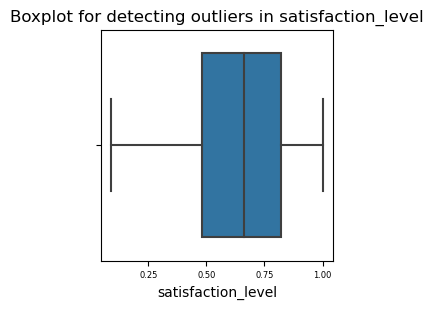

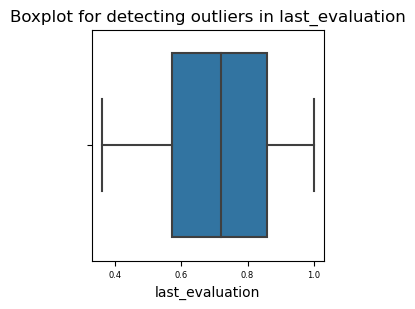

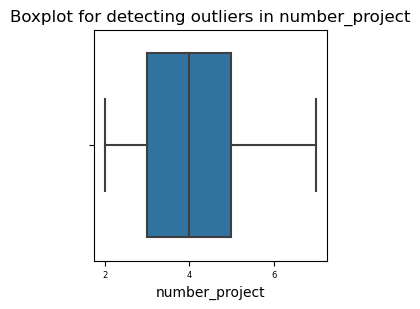

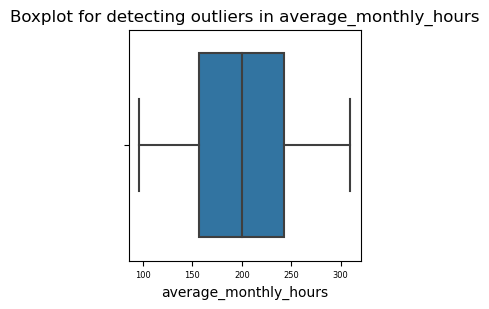

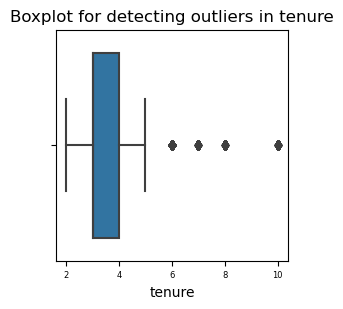

In [42]:
selected_columns = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']
for i, column in enumerate(selected_columns):
    plt.figure(figsize=(3,3))
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot for detecting outliers in {column}')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.show()


Le boxplot ci-dessus montre qu'il existe des valeurs aberrantes dans la variable "durée d'emploi" (tenure).

Il serait utile d'examiner combien de lignes des données contiennent des valeurs aberrantes dans la colonne de l'ancienneté.

In [24]:
percentile25 = data['tenure'].quantile(0.25)
percentile75 = data['tenure'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5*iqr
lower_limit = percentile25 - 1.5*iqr

outliers = data[(data['tenure']> upper_limit) | (data['tenure']< lower_limit)]
print("Nombre de lignes dans les données contenant des valeurs aberrantes dans `tenure` :", len(outliers))

Nombre de lignes dans les données contenant des valeurs aberrantes dans `tenure` : 824


## Phase d'analyse

Commencer par comprendre combien de salariés sont partis et quel pourcentage de l'ensemble des employés ce chiffre représente.

In [43]:
print(data['left'].value_counts())
print()

print(data['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Nombre de projet par rapport aux heures moyennes mensuelles')

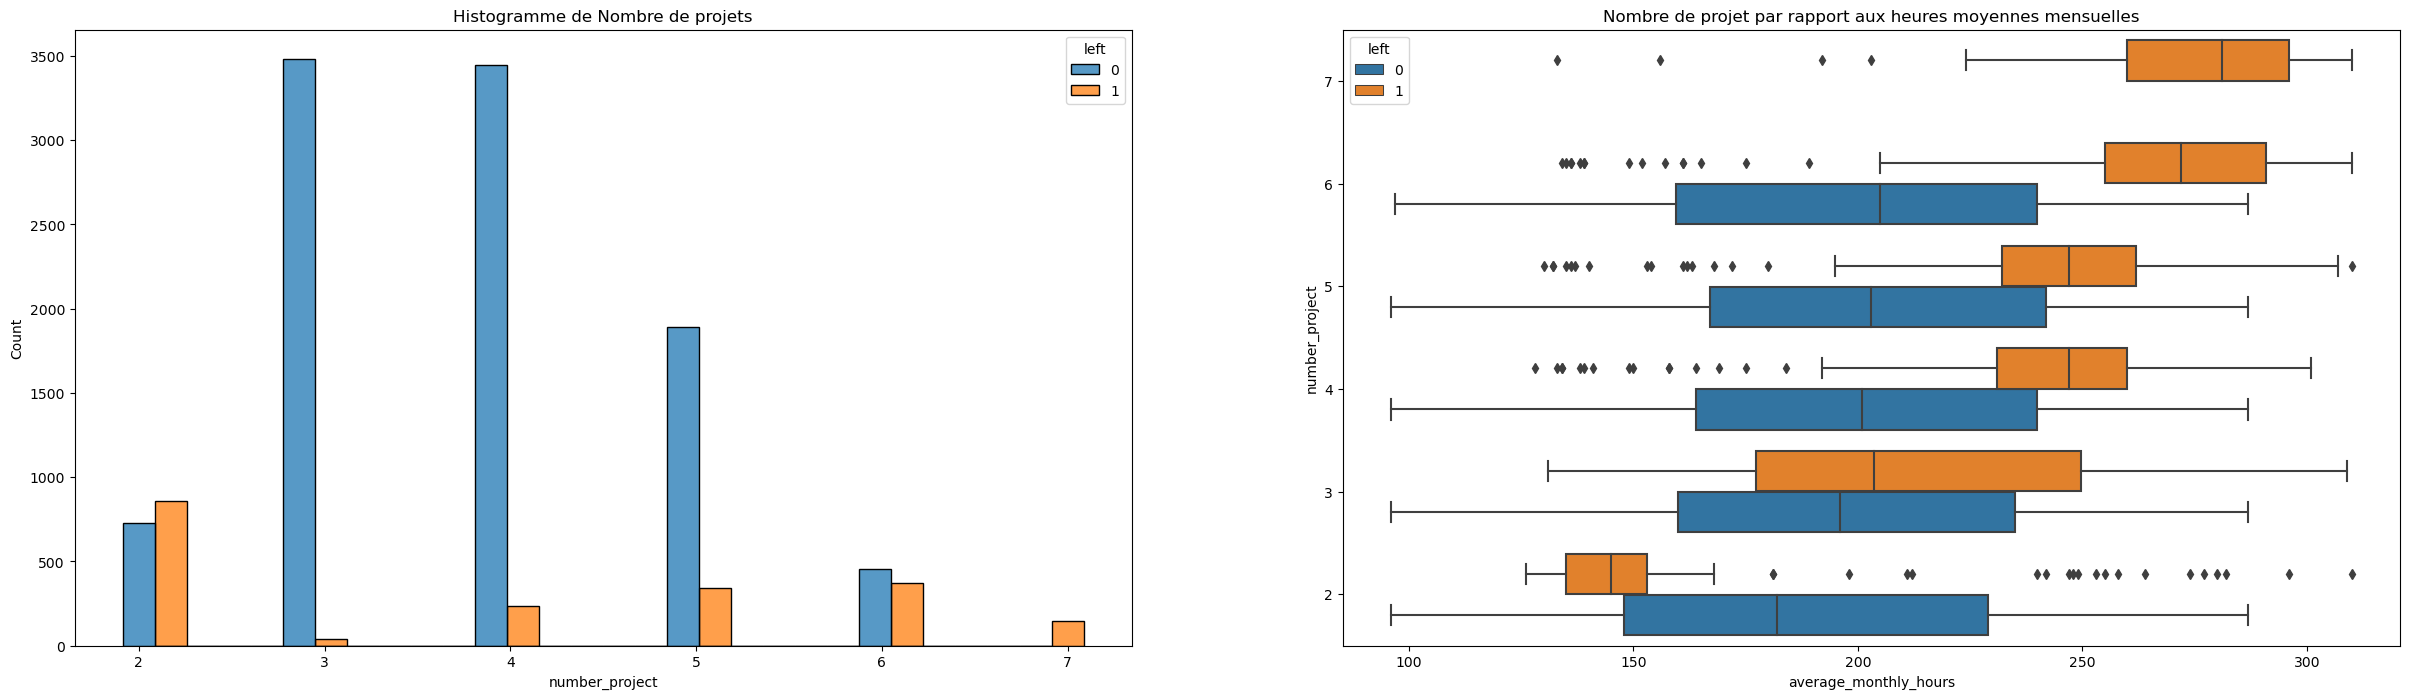

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

sns.histplot(data=data, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[0])
ax[0].set_title('Histogramme de Nombre de projets')

sns.boxplot(data=data, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Nombre de projet par rapport aux heures moyennes mensuelles')


Il pourrait être logique que les personnes qui travaillent sur un plus grand nombre de projets travaillent également plus longtemps. Cela semble être le cas ici, les heures moyennes de chaque groupe (resté et quitté) augmentant avec le nombre de projets travaillés. Toutefois, quelques éléments ressortent de ce graphique. Deux groupes d'employés ont quitté l'entreprise :

(A) Ceux qui ont travaillé beaucoup moins que leurs pairs pour le même nombre de projets.

(B) Ceux qui ont travaillé beaucoup plus. Il est possible que les employés du groupe A aient été licenciés. 

Pour ceux du groupe B, il est raisonnable de déduire qu'ils ont probablement démissionné. Les personnes du groupe B ont probablement beaucoup contribué aux projets dans lesquels elles travaillaient ; elles ont peut-être été celles qui ont le plus contribué à leurs projets.

Tous ceux qui avaient 7 projets ont quitté l'entreprise, et l'intervalle interquartile de ce groupe et de ceux qui ont quitté avec 6 projets était de ~255-295 heures/semaine - bien plus que pour tous les autres groupes.

Le nombre optimal de projets sur lesquels les employés peuvent travailler semble être de 3 à 4. Le rapport entre les employés qui quittent l'entreprise et ceux qui y restent est très faible pour ces cohortes.

Si l'on suppose une semaine de travail de 40 heures et deux semaines de vacances par an, le nombre moyen d'heures de travail par mois des employés travaillant du lundi au vendredi = 50 semaines * 40 heures par semaine / 12 mois = 166,67 heures par mois. Cela signifie qu'à l'exception des employés qui ont travaillé sur deux projets, tous les groupes - même ceux qui n'ont pas quitté l'entreprise - ont travaillé beaucoup plus d'heures que cela. Il semble que les employés soient surchargés de travail.

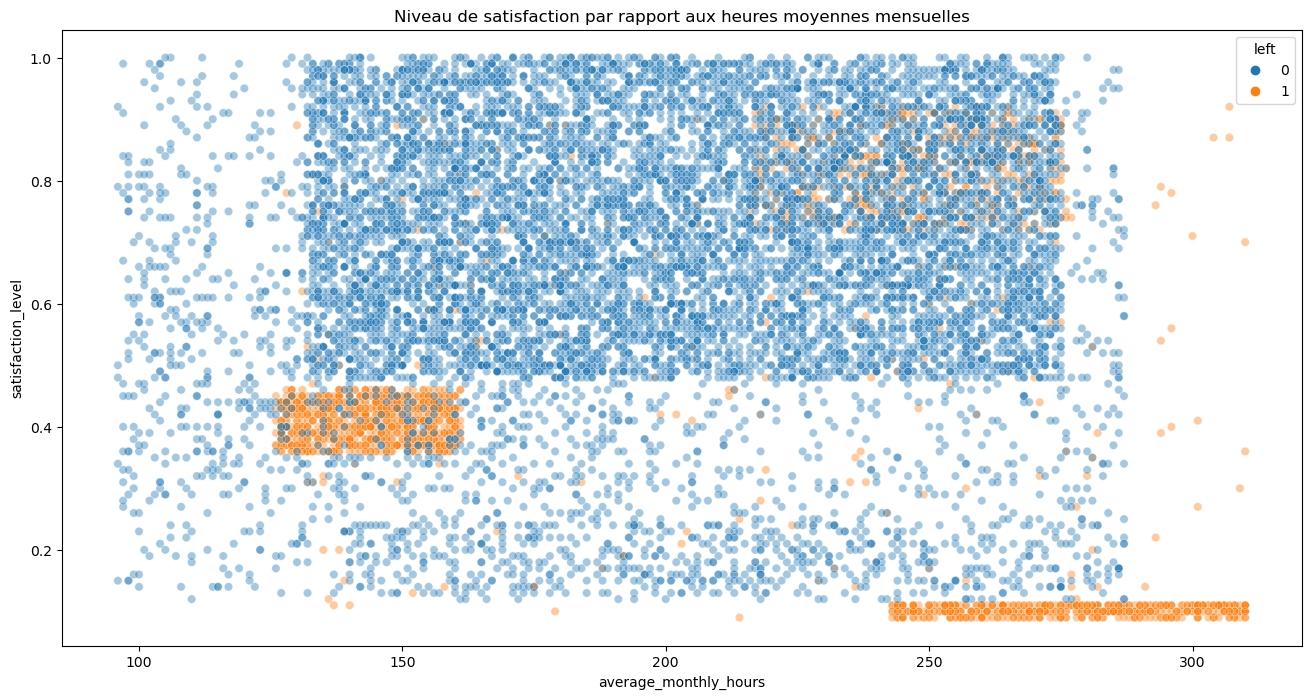

In [32]:
plt.figure(figsize=(16, 8))
sns.scatterplot(data=data, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.title('Niveau de satisfaction par rapport aux heures moyennes mensuelles')
plt.show()

Le nuage de points ci-dessus montre qu'un groupe important de salariés a travaillé ~240&ndash;315 heures par mois. 315 heures par mois, c'est plus de 75 heures par semaine pendant une année entière. Il est probable que cela soit lié au fait que leur niveau de satisfaction est proche de zéro.

Le graphique montre également un autre groupe de personnes qui sont parties, celles qui avaient des horaires de travail plus normaux. Malgré cela, leur niveau de satisfaction n'était que d'environ 0,4. Il est difficile de spéculer sur les raisons de leur départ. Il est possible qu'ils se soient sentis obligés de travailler plus, étant donné que beaucoup de leurs pairs travaillaient plus. Cette pression a pu réduire leur niveau de satisfaction.

Enfin, il y a un groupe qui a travaillé ~210&ndash;280 heures par mois, et dont les niveaux de satisfaction varient entre ~0,7&ndash;0,9.

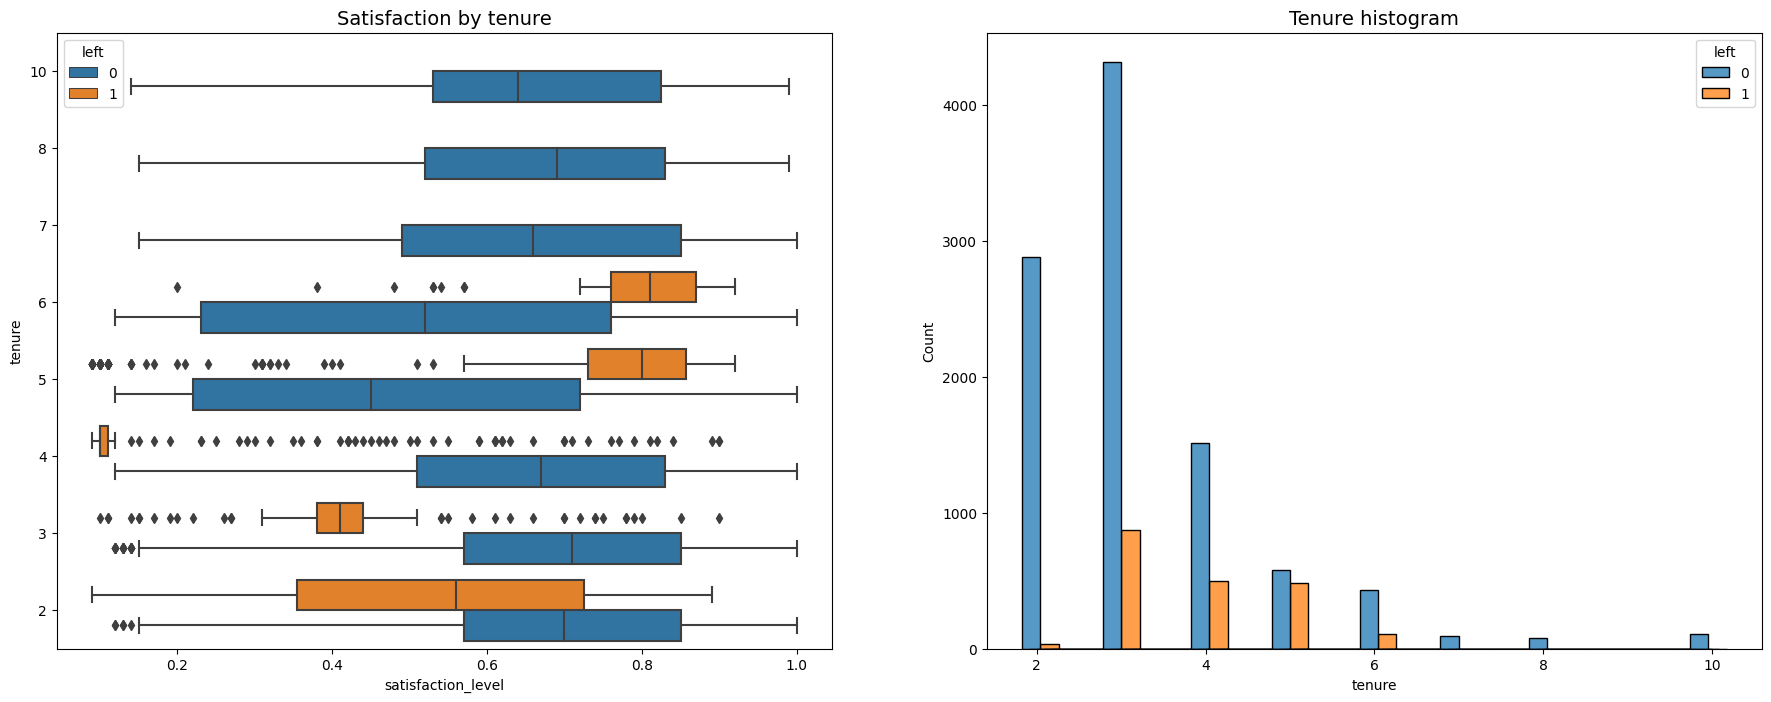

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))

sns.boxplot(data=data, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

sns.histplot(data=data, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show()

De nombreuses observations peuvent être faites à partir de ce graphique.

Les employés qui ont quitté l'entreprise se répartissent en deux catégories générales : les employés insatisfaits ayant une courte durée d'emploi et les employés très satisfaits ayant une durée d'emploi moyenne.
Les employés ayant une ancienneté de quatre ans qui ont quitté l'entreprise semblent avoir un niveau de satisfaction inhabituellement bas. Il est intéressant d'étudier les changements de politique de l'entreprise qui ont pu affecter les personnes ayant quitté l'entreprise après quatre ans d'ancienneté, si possible.
Les employés les plus anciens n'ont pas quitté l'entreprise. Leur niveau de satisfaction s'est aligné sur celui des nouveaux employés qui sont restés.

L'histogramme montre qu'il y a relativement peu d'employés de longue date. Il est possible qu'il s'agisse des employés les plus haut placés et les mieux payés.

calculer les taux de satisfaction moyen et médian des employés qui sont partis et de ceux qui ne sont pas restés

In [ ]:
data.groupby(['left'])['satisfaction_level'].agg([np.mean, np.median])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


Comme prévu, les notes de satisfaction moyenne et médiane des employés qui ont quitté l'entreprise sont inférieures à celles des employés qui sont restés. Il est intéressant de noter que parmi les employés qui sont restés, la note de satisfaction moyenne semble être légèrement inférieure à la note médiane. Cela indique que les niveaux de satisfaction de ceux qui sont restés pourraient être biaisés vers la gauche.

Examiner les niveaux de salaire pour différentes durées d'emploi.

Text(0.5, 1.0, 'Salary histogram by tenure')

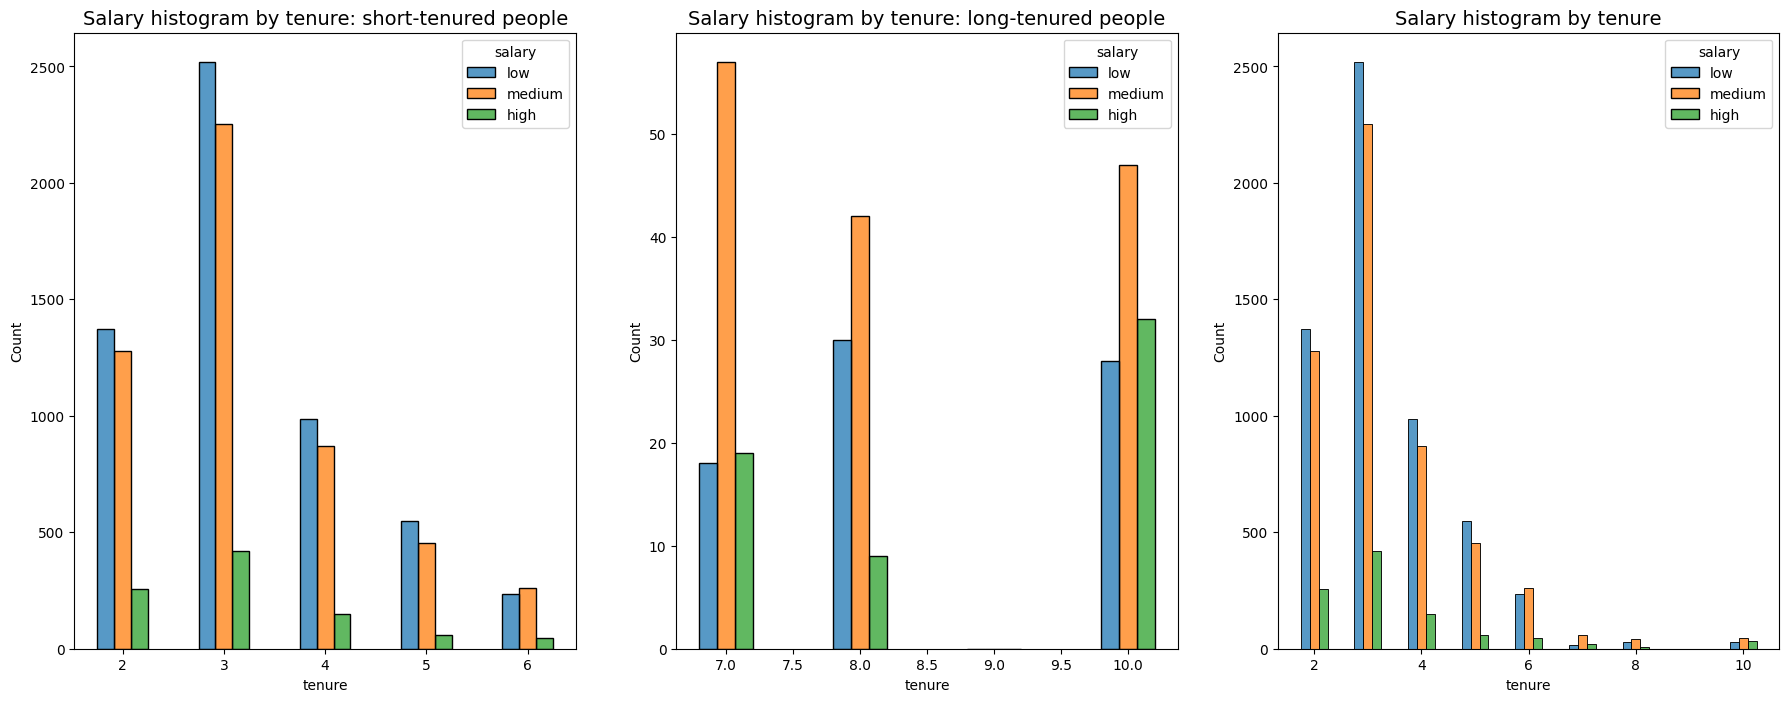

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (22,8))

tenure_short = data[data['tenure'] < 7]

tenure_long = data[data['tenure'] > 6]

sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14')

sns.histplot(data=data, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[2])
ax[2].set_title('Salary histogram by tenure', fontsize='14')

Les graphiques ci-dessus montrent que les employés de longue durée ne sont pas constitués de manière disproportionnée d'employés mieux rémunérés.

Text(0.5, 1.0, 'Monthly hours by last evaluation score')

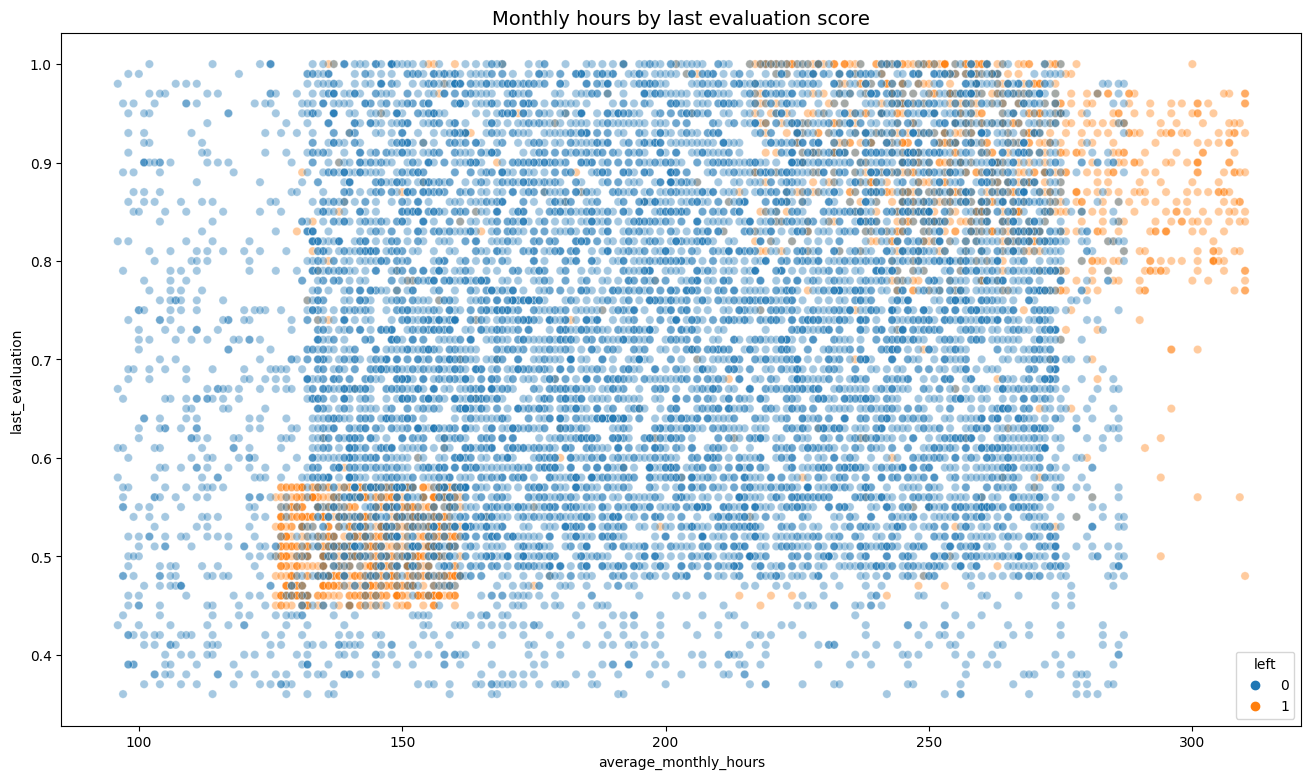

In [ ]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=data, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.title('Monthly hours by last evaluation score', fontsize='14')

Les observations suivantes peuvent être faites à partir du nuage de points ci-dessus :

Le nuage de points indique que deux groupes d'employés ont quitté l'entreprise : les employés surchargés qui ont obtenu de très bons résultats et les employés qui ont travaillé un peu moins que la moyenne mensuelle nominale de 166,67 heures et qui ont obtenu de moins bonnes notes d'évaluation.
Il semble y avoir une corrélation entre les heures travaillées et la note d'évaluation.
Il n'y a pas un pourcentage élevé de salariés dans le quadrant supérieur gauche de ce graphique, mais le fait de travailler de longues heures ne garantit pas une bonne note d'évaluation.

La plupart des employés de cette entreprise travaillent bien plus de 167 heures par mois.

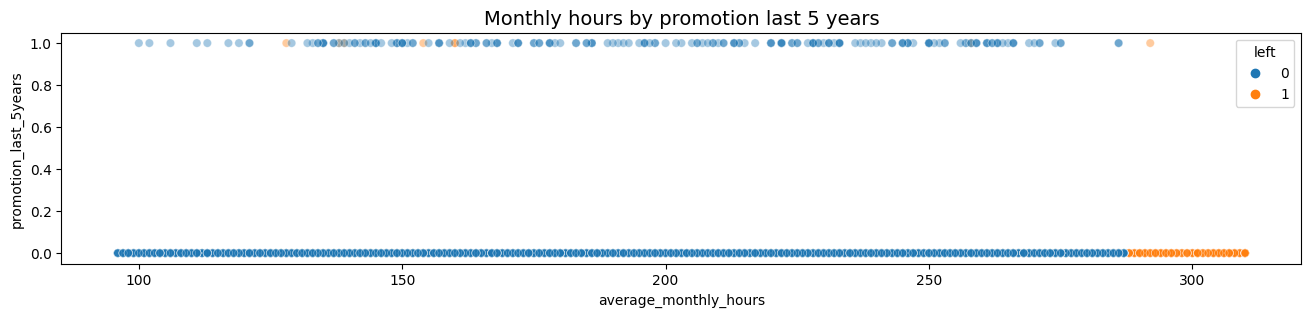

In [ ]:
plt.figure(figsize=(16, 3))
sns.scatterplot(data=data, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

Le graphique ci-dessus montre ce qui suit :

très peu de salariés promus au cours des cinq dernières années sont partis
très peu de salariés qui travaillaient le plus d'heures ont été promus
tous les employés qui sont partis travaillaient les heures les plus longues
Ensuite, nous pouvons examiner comment les employés qui sont partis sont répartis entre les départements.

In [ ]:
data['department'].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

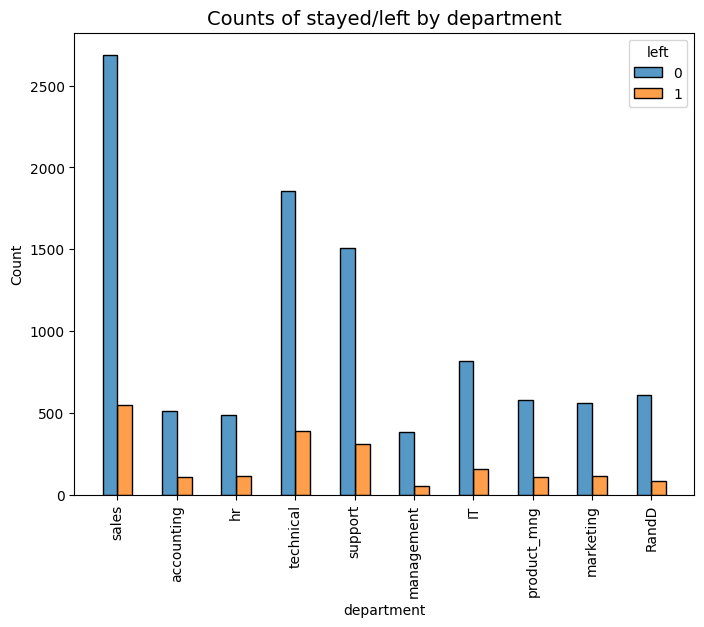

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='department', hue='left', discrete=1,
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation='vertical')
plt.title('Counts of stayed/left by department', fontsize=14);

Il ne semble pas y avoir de département qui se différencie de manière significative dans la proportion de salariés qui sont partis et de ceux qui sont restés.

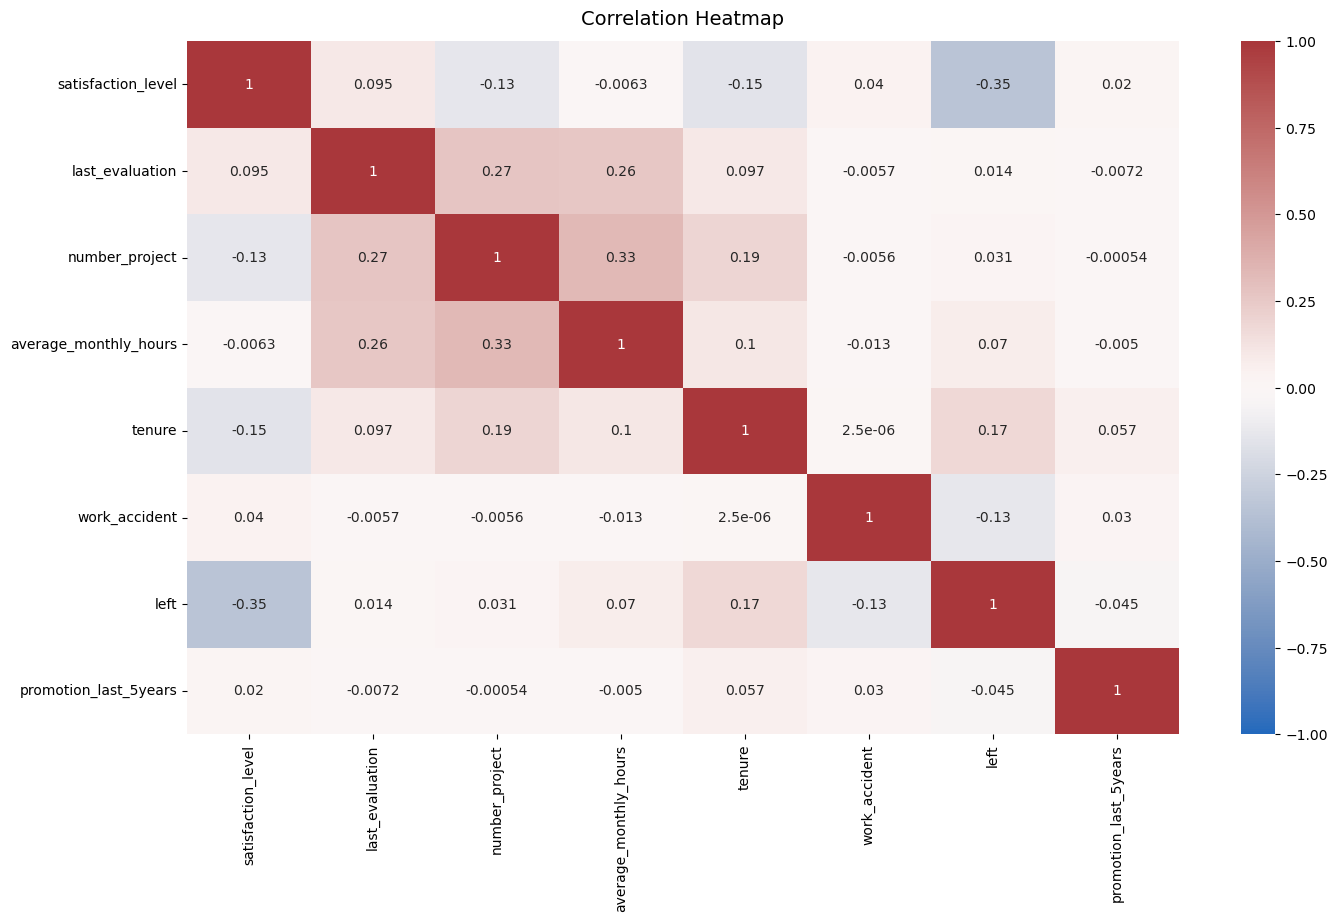

In [45]:
data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(data.select_dtypes(include=['float64', 'int64']).corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

La carte de corrélation confirme que le nombre de projets, les heures mensuelles et les notes d'évaluation ont tous une certaine corrélation positive entre eux, et que le départ d'un employé est négativement corrélé à son niveau de satisfaction.

### Perspectives

Il semble que les employés quittent l'entreprise en raison d'une mauvaise gestion. Les départs sont liés à des heures de travail plus longues, à de nombreux projets et à des niveaux de satisfaction généralement plus faibles. Il peut être peu gratifiant de travailler de longues heures et de ne pas recevoir de promotions ou de bonnes notes d'évaluation. Il y a dans cette entreprise un groupe important d'employés qui sont probablement épuisés. Il semble également que si un employé a passé plus de six ans dans l'entreprise, il a tendance à ne pas la quitter.

## Construction des modèles

- Ajuster un modèle qui prédit la variable de résultat à l'aide de deux variables indépendantes ou plus
- Vérifier les hypothèses du modèle
- Évaluer le modèle

### 1- Logistic Regression

**Hypothèses du modèle de régression logistique**
- La variable de résultat est catégorique
- Les observations sont indépendantes les unes des autres
- Pas de multicolinéarité grave entre les variables X 
- Pas de valeurs aberrantes extrêmes
- Relation linéaire entre chaque variable X et le logit de la variable de résultat
- Taille de l'échantillon suffisamment importante 

Avant de diviser les données, il faut coder les variables non numériques. Il y en a deux : le département et le salaire.

Le département est une variable catégorielle, ce qui signifie qu'il faut lui attribuer une valeur dummy pour la modélisation.

Le salaire est également catégorique, mais il est ordinal. Il existe une hiérarchie entre les catégories, il est donc préférable de ne pas mettre cette colonne sous forme de variable muette, mais plutôt de convertir les niveaux en nombres, de 0 à 2.

In [46]:
data_enc = data.copy()

data_enc['salary'] = (
    data_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)
data_enc = pd.get_dummies(data_enc, drop_first=False)
data_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


Créer une carte de corrélation pour visualiser la corrélation entre les variables.

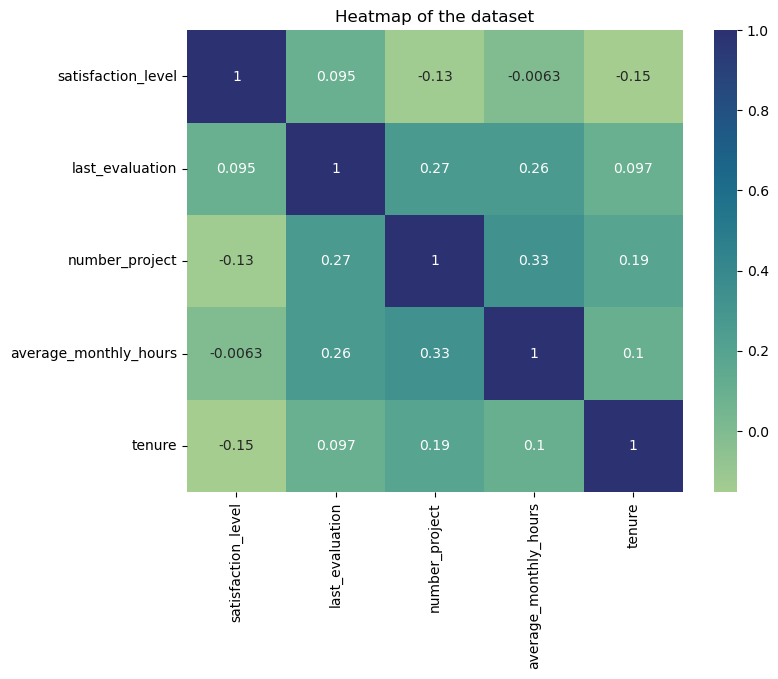

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(data_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']].corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

La régression logistique étant assez sensible aux valeurs aberrantes, il serait judicieux, à ce stade, de supprimer les valeurs aberrantes de la colonne "tenure" qui ont été identifiées précédemment.

<Axes: xlabel='tenure'>

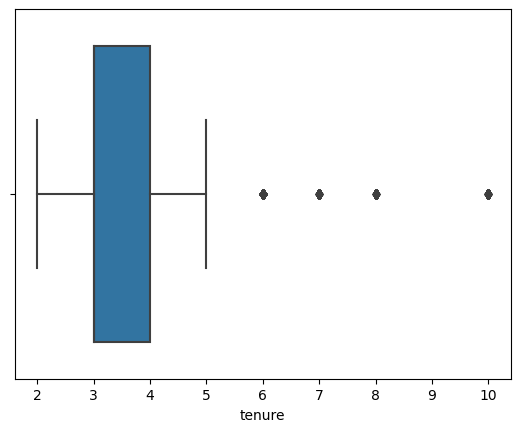

In [ ]:
sns.boxplot(data=data, x='tenure')

In [48]:
data_logreg = data_enc[(data_enc['tenure'] >= lower_limit) & (data_enc['tenure'] <= upper_limit)]
data_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [49]:
data_logreg.shape

(11167, 19)

In [50]:
y = data_logreg['left']
X = data_logreg.drop('left', axis=1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [52]:
log_clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)

In [53]:
y_pred = log_clf.predict(X_test)

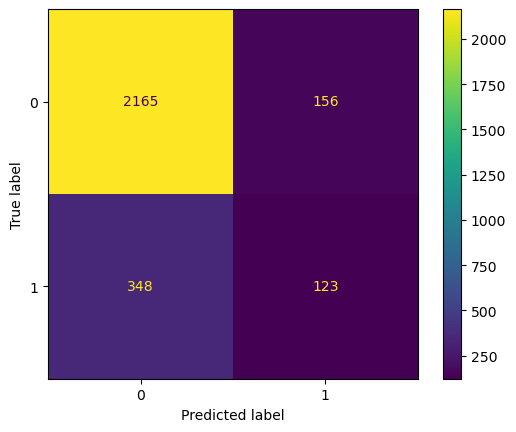

In [54]:
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,
                                  display_labels=log_clf.classes_)

log_disp.plot(values_format='')
plt.show()

Vérifier l'équilibre des classes dans les données. En d'autres termes, vérifiez le nombre de valeurs dans la colonne de gauche. Comme il s'agit d'une tâche de classification binaire, l'équilibre des classes renseigne sur la manière dont nous interprétons les mesures de précision.

In [56]:
data_logreg['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

La répartition est d'environ 83%-17%. Les données ne sont donc pas parfaitement équilibrées, mais elles ne le sont pas trop. Dans ce cas, j'utiliserai ces données sans modifier l'équilibre des classes et continuer à évaluer le modèle.

In [ ]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.45      0.27      0.34       471

                 accuracy                           0.82      2792
                macro avg       0.66      0.60      0.62      2792
             weighted avg       0.79      0.82      0.80      2792



Le rapport de classification ci-dessus montre que le modèle de régression logistique a obtenu une précision de 79 %, un rappel de 82 %, un score f1 de 80 % (toutes les moyennes pondérées) et une exactitude (accuracy) de 82 %. Toutefois, s'il est plus important de prédire les employés qui quittent l'entreprise, les résultats sont nettement inférieurs.

### 2- Modèle Decision-Tree

In [114]:
y = data_enc['left']
X = data_enc.drop('left', axis=1)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [116]:
tree = DecisionTreeClassifier(random_state=42)
cv_params = {'max_depth': [2, 3, 4, None],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4]}

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [117]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 4.31 s
Wall time: 4.31 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [118]:
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}

In [119]:
y_pred = tree1.predict(X_test)

In [120]:
tree1.best_score_

0.9731261100199281

Il s'agit d'un score AUC élevé, qui montre que ce modèle peut très bien prédire les employés qui quitteront l'entreprise.

In [121]:
def make_results(model_name:str, model_object, metric:str):

    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    cv_results = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })

    return table

In [122]:
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.925043,0.915607,0.920245,0.973647,0.973126


Tous ces résultats du modèle d'arbre décisionnel sont de bons indicateurs de la performance du modèle.

### 3- Random Forest

In [123]:
rf = RandomForestClassifier(random_state=42)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [124]:
%%time
rf1.fit(X_train, y_train)

CPU times: total: 29min 5s
Wall time: 29min 8s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [125]:
rf1.best_score_

0.9821774263690365

Il s'agit d'un score AUC élevé, qui montre que ce modèle peut très bien prédire les employés qui quitteront l'entreprise.

In [126]:
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [128]:
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.925043  0.915607  0.920245  0.973647  0.973126
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.945895  0.912254  0.928698   0.97676  0.982177


Les scores d'évaluation du modèle de forêt aléatoire sont meilleurs que ceux du modèle d'arbre décisionnel, à l'exception du rappel (le score de rappel du modèle de forêt aléatoire est inférieur d'environ 0,003, ce qui est négligeable). Cela indique que le modèle de forêt aléatoire est généralement plus performant que le modèle d'arbre décisionnel.

Evaluer le modèle final sur l'ensemble de tests.

In [129]:
def get_scores(model_name:str, model, X_test_data, y_test_data):

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })

    return table

In [130]:
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.95842,0.925703,0.941777,0.980987,0.958851


Les résultats des tests sont très proches des résultats de la validation, ce qui est une bonne chose. Il s'agit donc d'un modèle solide.

### Feature Engineering

Les notes d'évaluation élevées peuvent etre sceptique. Il est possible qu'il y ait des fuites de données. 

Il y a fuite de données lorsque nous utilisons pour entraîner notre modèle des données qui ne devraient pas être utilisées pendant l'entraînement, soit parce qu'elles apparaissent dans les données de test, soit parce qu'il ne s'agit pas de données que nous attendons à avoir lorsque le modèle sera réellement déployé. 

L'entraînement d'un modèle à l'aide de données ayant fait l'objet d'une fuite peut donner un résultat irréaliste qui ne sera pas reproduit dans la production.

Dans ce cas, il est probable que l'entreprise ne disposera pas de niveaux de satisfaction pour l'ensemble de ses employés. Il est également possible que la colonne average_monthly_hours soit une source de fuite de données. Si les employés ont déjà décidé de démissionner ou ont déjà été identifiés par la direction comme des personnes à licencier, il se peut qu'ils travaillent moins d'heures.

Je vais supprimer la variable niveau_de_satisfaction et créer une nouvelle caractéristique qui indique grosso modo si un employé est surchargé de travail. Il s'agira d'une variable binaire.

In [132]:
data2 = data_enc.drop('satisfaction_level', axis=1)
data2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [133]:
data2['overworked'] = data2['average_monthly_hours']
print('Max hours:', data2['overworked'].max())
print('Min hours:', data2['overworked'].min())

Max hours: 310
Min hours: 96


166,67 est approximativement le nombre moyen d'heures mensuelles d'une personne qui travaille 50 semaines par an, 5 jours par semaine, 8 heures par jour.

In [134]:
data2['overworked'] = (data2['overworked'] > 175).astype(int)
data2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int32

In [135]:
data2 = data2.drop('average_monthly_hours', axis=1)
data2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


In [136]:
y = data2['left']
X = data2.drop('left', axis=1)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

### Decision Tree - Round 2

In [154]:
tree = DecisionTreeClassifier(random_state=42)

cv_params = {'max_depth': [2, 3, 4, None],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4]}

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [155]:
%%time
tree2.fit(X_train, y_train)

CPU times: total: 3.75 s
Wall time: 3.76 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [156]:
tree2.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [157]:
tree2.best_score_

0.9551312368281457

Ce modèle donne de très bons résultats, même en l'absence de niveaux de satisfaction et de données détaillées sur les heures travaillées.

In [158]:
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.925043  0.915607  0.920245  0.973647  0.973126
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.784433  0.887457  0.832267  0.940731  0.955131


Certains des autres scores ont baissé. C'est normal, étant donné que moins de caractéristiques ont été prises en compte dans cette version du modèle. Néanmoins, les résultats sont très bons.

### Random Forest - Round 2

In [159]:
rf = RandomForestClassifier(random_state=42)
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [160]:
%%time
rf2.fit(X_train, y_train)

CPU times: total: 21min 10s
Wall time: 21min 13s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [161]:
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

In [162]:
rf2.best_score_

0.9652279226582176

In [163]:
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.784433  0.887457  0.832267  0.940731  0.955131
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv     0.8652  0.875401  0.870017  0.956633  0.965228


Là encore, les scores ont légèrement baissé, mais la forêt aléatoire est plus performante que l'arbre de décision si l'on utilise la AUC comme critère de décision.

In [164]:
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.869732,0.911647,0.890196,0.962642,0.942223


Il semble s'agir d'un modèle final stable et performant.

Tracer une matrice de confusion pour visualiser la qualité de la prédiction sur l'ensemble de test.

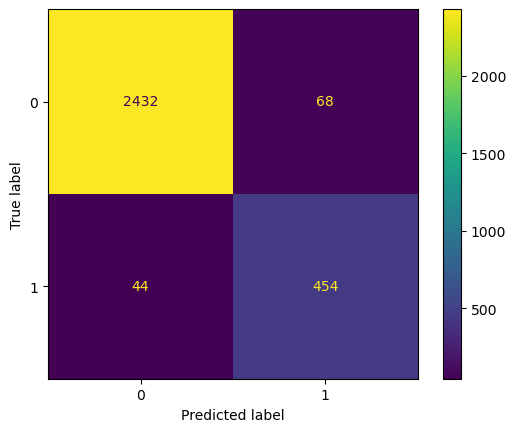

In [165]:
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

Le modèle prédit plus de faux positifs que de faux négatifs, ce qui signifie que certains employés peuvent être identifiés comme risquant de démissionner ou d'être licenciés, alors que ce n'est pas le cas. Il s'agit néanmoins d'un modèle solide.

In [166]:
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_,
                                 columns=['gini_importance'],
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

,gini_importance
last_evaluation,0.391116
number_project,0.360575
tenure,0.184528
overworked,0.063398
department_sales,0.000383


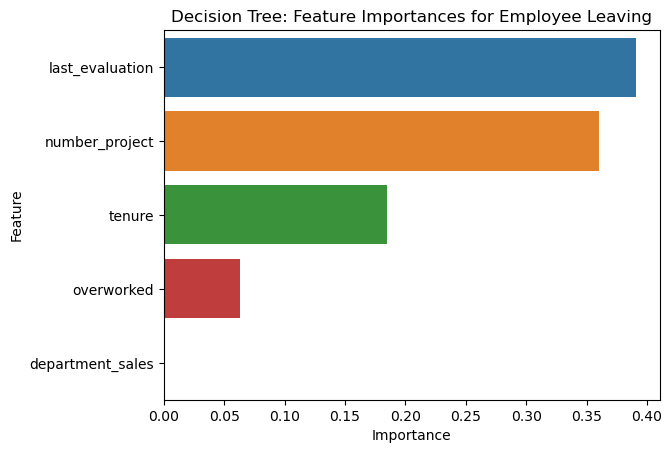

In [167]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

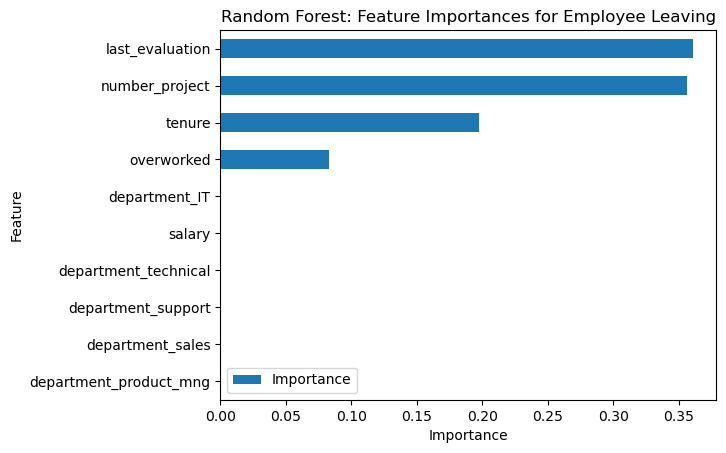

In [168]:
feat_impt = rf2.best_estimator_.feature_importances_

ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

feat = X.columns[ind]
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

Le graphique ci-dessus montre que dans ce modèle de forêt aléatoire, la dernière évaluation, le nombre de projets, la titularisation et la surcharge de travail ont la plus grande importance, dans cet ordre. Ces variables sont les plus utiles pour prédire la variable de résultat, gauche, et sont les mêmes que celles utilisées par le modèle d'arbre de décision.

## Résumé des résultats des modèles

**Régression logistique**

Le modèle de régression logistique a obtenu une précision de 80 %, un rappel de 83 %, un score f1 de 80 % (toutes les moyennes pondérées) et une exactitude de 83 % sur l'ensemble de test.

**Apprentissage automatique à base d'arbres**

Après avoir procédé à l'ingénierie des caractéristiques, le modèle d'arbre de décision a obtenu une AUC de 94 %, une précision de 86,0 %, un rappel de 91 %, un score f1 de 89 % et une précision de 96,2 %, sur l'ensemble de test. La forêt aléatoire a légèrement surpassé le modèle d'arbre de décision. 

# Conclusion

Les modèles et les importances des caractéristiques extraites des modèles confirment que les employés de l'entreprise sont surchargés de travail. 

Pour retenir les employés, les recommandations suivantes pourraient être présentées aux parties prenantes :

* Limiter le nombre de projets sur lesquels les employés peuvent travailler.
* Envisager de promouvoir les employés qui travaillent dans l'entreprise depuis au moins quatre ans, ou mener une enquête plus approfondie sur les raisons pour lesquelles les employés ayant quatre ans d'ancienneté sont si insatisfaits. 
* Récompenser les employés qui travaillent plus longtemps ou ne pas les obliger à le faire. 
* Si les employés ne connaissent pas la politique de l'entreprise en matière de rémunération des heures supplémentaires, informez-les. Si les attentes concernant la charge de travail et les congés ne sont pas explicites, précisez-les. 
* Organisez des discussions à l'échelle de l'entreprise et au sein des équipes afin de comprendre et d'aborder la culture de travail de l'entreprise, de manière générale et dans des contextes spécifiques. 
* Les notes d'évaluation élevées ne doivent pas être réservées aux employés qui travaillent plus de 200 heures par mois. Envisagez une échelle proportionnelle pour récompenser les employés qui contribuent davantage ou fournissent plus d'efforts. 